In [4]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
import pandas as pd
import numpy as np
import imp, sys
sys.path.append('./src/')
import feature_utils
import seaborn as sns
import doc_utils_clean as doc_utils
import matplotlib.pyplot as plt
from matplotlib import rcParamsDefault
import defines
import glob
import os
import pandas as pd 

In [11]:
 
sent_pos_db_map = {}
sent_tokens_db_list = glob.glob(os.path.join('dataframes', "*sent_pos_db.csv"))
for i,doc_name in enumerate(sent_tokens_db_list):
    doc_prefix = int(os.path.basename(doc_name).split("_")[0])
    sent_pos_db_map[doc_prefix] = pd.read_csv(doc_name)

In [12]:
sent_pos_db_map.keys()

dict_keys([4, 5, 8, 6, 7, 1, 3, 2])

In [13]:
for i in sent_pos_db_map.keys():
    print (sent_pos_db_map[i].isna().any())

FROM         False
sent_idx     False
TO           False
FORM         False
LEMMA        False
CPOSTAG      False
POSTAG       False
FEATS        False
f_gen         True
f_num         True
TOKEN        False
f_suf_gen     True
f_suf_num     True
f_suf_per     True
f_per         True
f_tense       True
doc_idx      False
dtype: bool
FROM         False
sent_idx     False
TO           False
FORM         False
LEMMA        False
CPOSTAG      False
POSTAG       False
FEATS        False
TOKEN        False
f_gen         True
f_num         True
f_suf_gen     True
f_suf_num     True
f_suf_per     True
f_per         True
f_tense       True
doc_idx      False
dtype: bool
FROM         False
sent_idx     False
TO           False
FORM         False
LEMMA        False
CPOSTAG      False
POSTAG       False
FEATS        False
f_gen         True
f_num         True
TOKEN        False
f_per         True
f_tense       True
f_suf_gen     True
f_suf_num     True
f_suf_per     True
doc_idx      False
dtype: 

In [14]:
take_columns = ['sent_len','fist_sent_in_nar','last_sent_in_nar','is_client','is_nar']

In [19]:
sent_db_map = {}
sent_db_list = glob.glob(os.path.join('dataframes', "*sent_db.csv"))
for i,doc_name in enumerate(sent_db_list):
    doc_prefix = int(os.path.basename(doc_name).split("_")[0])
    sent_db_map[doc_prefix] = pd.read_csv(doc_name)

In [20]:
sent_db_map.keys()

dict_keys([2, 4, 6, 5, 7, 8, 1, 3])

In [22]:
columns_to_count = ['POSTAG','f_gen','f_num','f_suf_gen','f_suf_num','f_suf_per','f_per','f_tense']
count_db_map = {}
def get_and_save_sent_pos_count_db(doc_idx):
    sent_pos_db = sent_pos_db_map[doc_idx]
    sent_pos_dummies = pd.get_dummies(sent_pos_db,columns=columns_to_count)
    sent_pos_dummies.fillna(value=0,inplace=True)
    count_db = sent_pos_dummies.groupby('sent_idx').sum()
    count_db['TOKEN'] = sent_pos_dummies.groupby('sent_idx')['TOKEN'].max()
    count_db.drop(['FROM','TO','doc_idx'],inplace=True,axis=1)
    count_db_map[doc_idx] = count_db
    count_db.to_csv(os.path.join(os.getcwd(),defines.PATH_TO_DFS,"{:02d}_sent_pos_count_db.csv".format(doc_idx)),index=False)
    print("{} sent count db saved".format(doc_idx))

for i in sent_pos_db_map.keys():
    get_and_save_sent_pos_count_db(i)

4 sent count db saved
5 sent count db saved
8 sent count db saved
6 sent count db saved
7 sent count db saved
1 sent count db saved
3 sent count db saved
2 sent count db saved


In [23]:
for i in count_db_map.keys():
    nan_col = count_db_map[i].columns[count_db_map[i].isna().any()]
    if (len(nan_col) > 0):
        print ("{} contains NaN {}".format(i, nan_col))

In [24]:
count_db_map[4].head()

,TOKEN,POSTAG_ADVERB,POSTAG_AT,POSTAG_BN,POSTAG_BNT,POSTAG_CC,POSTAG_CD,POSTAG_CDT,POSTAG_CONJ,POSTAG_COP,...,f_suf_per_2.0,f_suf_per_3.0,f_per_1,f_per_2,f_per_3,f_per_A,f_tense_BEINONI,f_tense_FUTURE,f_tense_IMPERATIVE,f_tense_PAST
sent_idx,,,,,,,,,,,,,,,,,,,,,
0.000000,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.000000,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.000000,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.000000,2,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4.000000,16,0,0,0,0,1,0,0,0,1,...,0,0,0,0,2,0,0,0,0,0


## Merge pos counter and features

In [25]:
sent_db_map[1].head()

,text,sent_idx_in_block,block_idx,is_nar,doc_idx,par_db_idx,par_idx_in_doc,par_type,block_type,nar_idx,sent_len,sent_idx_in_nar,nar_len_in_sent,sent_idx_out_nar,fist_sent_in_nar,last_sent_in_nar,is_client
0,אז היום אנחנו נפגשים פה ב18 אבל שבוע הבא בחמישי,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,therapist,not_nar,0.000000,47.000000,NaN,NaN,1.000000,False,False,0
1,כן,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,client,not_nar,0.000000,2.000000,NaN,NaN,1.000000,False,False,1
2,אוקיי,0.000000,2.000000,0.000000,1.000000,2.000000,3.000000,therapist,not_nar,0.000000,5.000000,NaN,NaN,1.000000,False,False,0
3,מה שלומך,1.000000,2.000000,0.000000,1.000000,2.000000,3.000000,therapist,not_nar,0.000000,8.000000,NaN,NaN,2.000000,False,False,0
4,ברוך השם,0.000000,3.000000,0.000000,1.000000,3.000000,4.000000,client,not_nar,0.000000,8.000000,NaN,NaN,1.000000,False,False,1


In [26]:
merged_sent_pos_db_map = {}
def merge_sent_pos_db(doc_idx):
    merged_sent_pos =  pd.merge(sent_db_map[doc_idx][['is_nar','is_client','sent_len']],count_db_map[doc_idx], left_index=True,right_index=True,validate="one_to_one")
    merged_sent_pos_db_map[doc_idx] = merged_sent_pos

for i in count_db_map.keys():
    merge_sent_pos_db(i)

In [28]:
def save_merged_sent_pos_db():
    for i in merged_sent_pos_db_map.keys():
        merged_sent_pos_db_map[i].to_csv(os.path.join(os.getcwd(),defines.PATH_TO_DFS,"{:02d}_merged_db.csv".format(i)),index=False)
save_merged_sent_pos_db()

## Compare features distribution between nar / not_nar

### Concat all documents features into single DataFrame

In [29]:
import scipy.stats as stats


def concat_all_merged_pos_db():
    db= pd.concat([merged_sent_pos_db_map[i] for i in merged_sent_pos_db_map.keys()])
    db.reset_index(inplace=True,drop=True)
    return db
    
merged_all_docs_db = concat_all_merged_pos_db()

In [30]:
merged_all_docs_db

,is_nar,is_client,sent_len,TOKEN,POSTAG_ADVERB,POSTAG_AT,POSTAG_BN,POSTAG_BNT,POSTAG_CC,POSTAG_CD,...,f_per_1,f_per_2,f_per_3,f_per_A,f_tense_BEINONI,f_tense_FUTURE,f_tense_IMPERATIVE,f_tense_PAST,POSTAG_P,POSTAG_NCD
0,0.000000,0,10.000000,3,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,0.000000,1,15.000000,3,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,0.000000,0,4.000000,1,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,0.000000,0,8.000000,2,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,0.000000,1,73.000000,16,0.000000,0,0,0,1,0,...,0,0,2,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,0.000000,1,389.000000,89,NaN,5,3,0,7,3,...,9,0,23,3,0,5,0,4,NaN,0.000000
3048,0.000000,0,639.000000,130,NaN,3,16,0,6,0,...,7,11,12,18,0,5,0,4,NaN,0.000000
3049,0.000000,1,19.000000,5,NaN,0,0,0,0,0,...,0,0,1,0,0,0,0,0,NaN,0.000000
3050,0.000000,0,395.000000,38,NaN,2,7,0,6,0,...,10,2,10,10,1,0,0,3,NaN,0.000000


### Compare distribution between nar/not_nar among all docs

In [388]:
import math
def get_axis_num(feature_list):
    total = len(feature_list)
    n = int(math.sqrt(total))
    return n,n+1

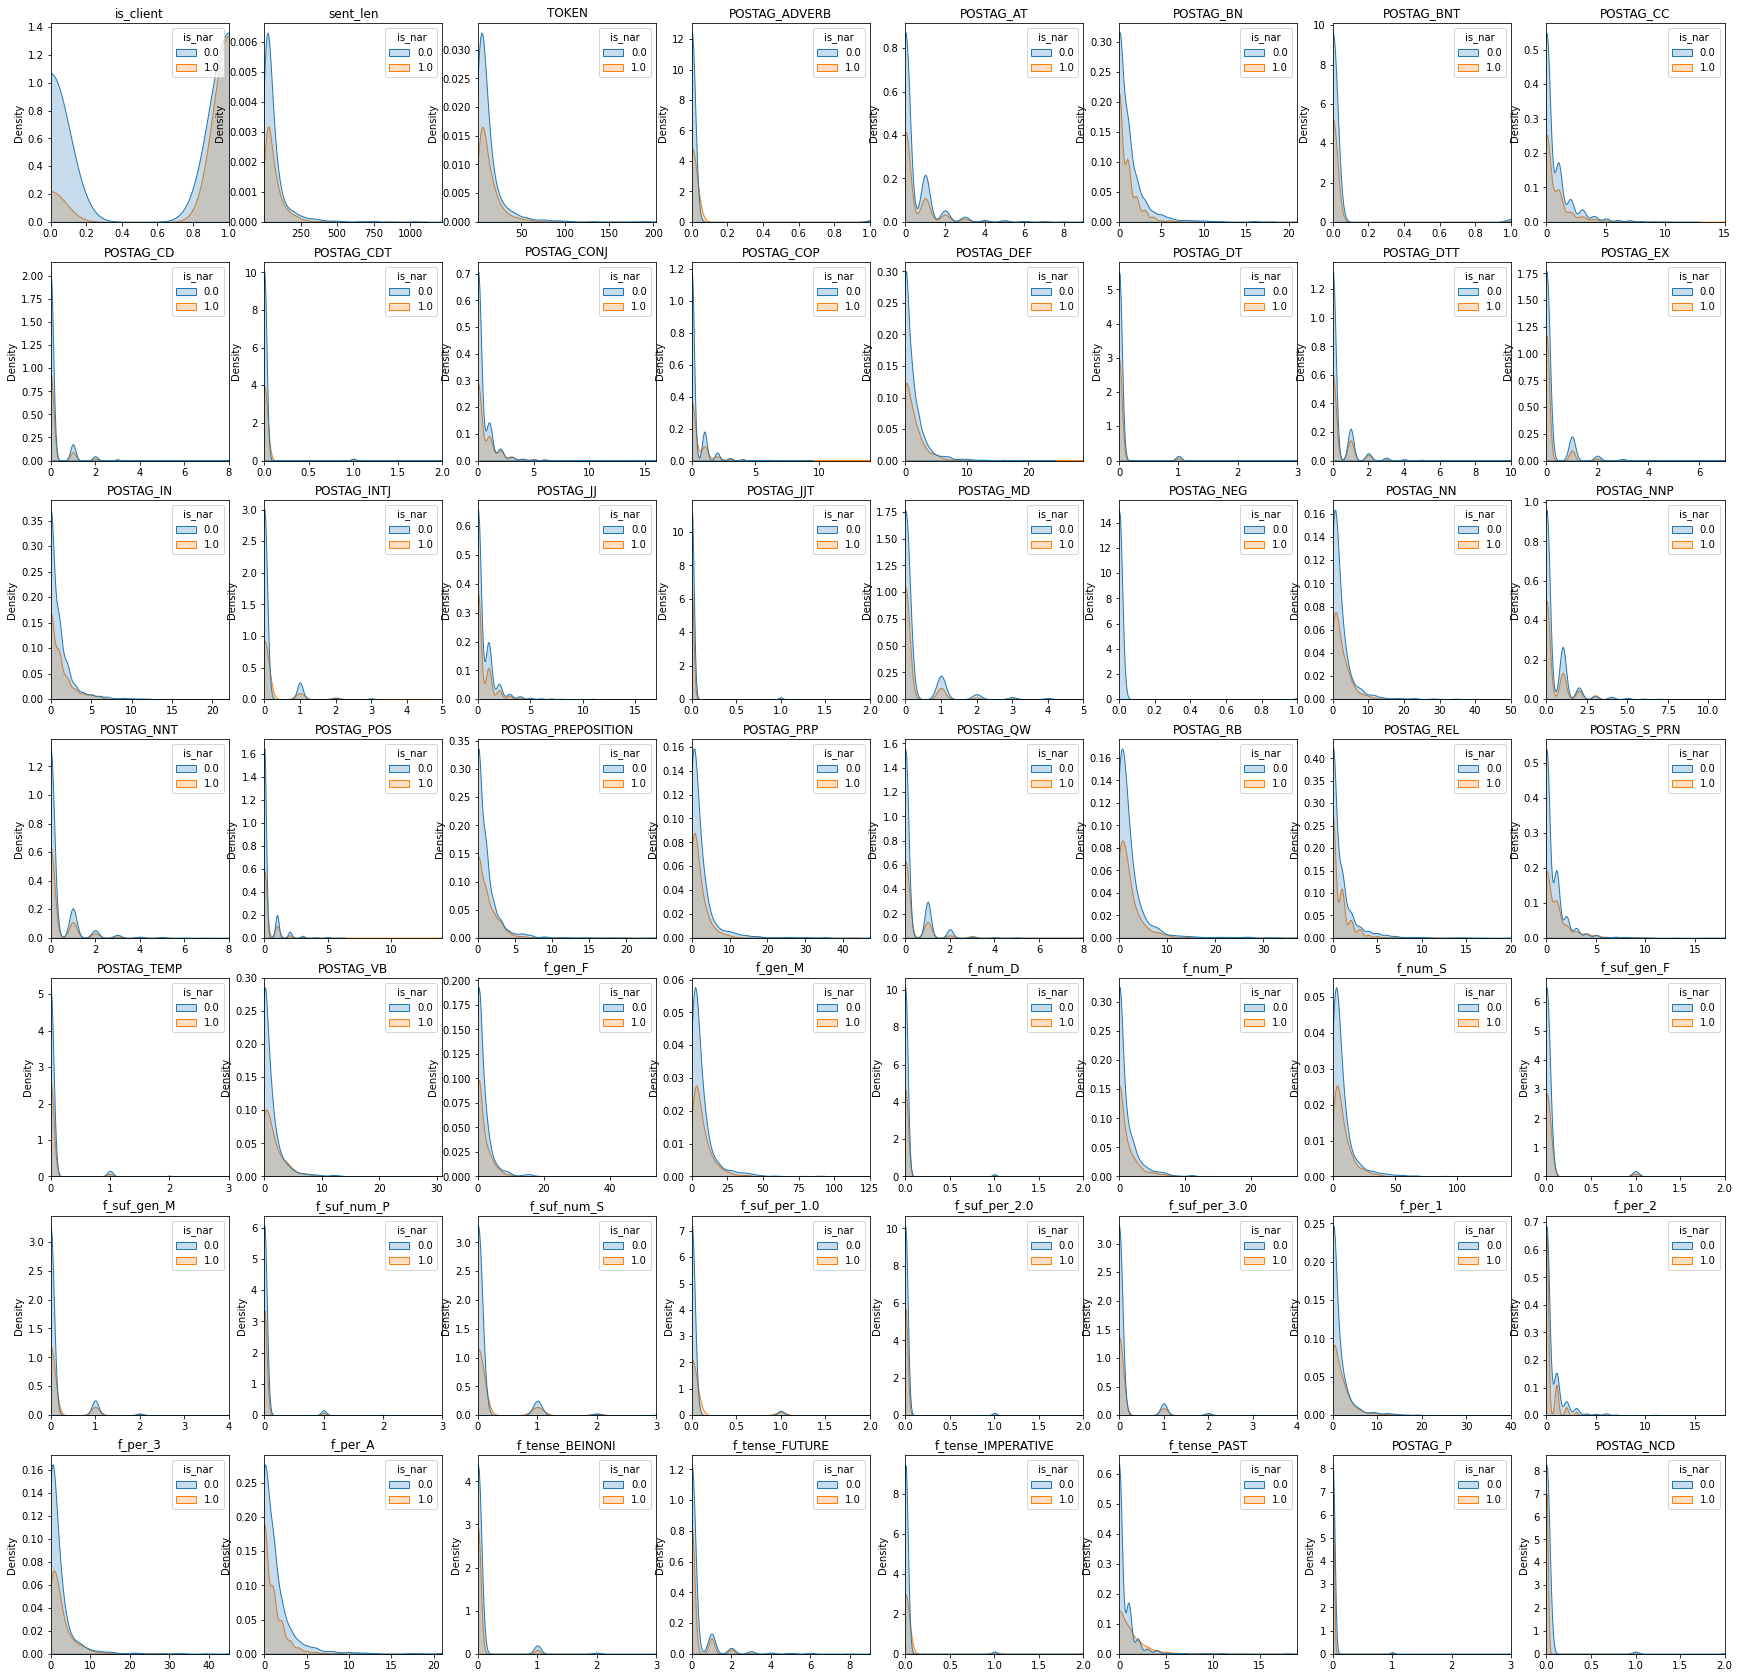

In [389]:
import matplotlib.pyplot as plt

db_to_plot = merged_all_docs_db
n,m=get_axis_num(db_to_plot.columns)
fig, axes = plt.subplots(nrows=n,ncols=m,figsize=(30,30))
cols = db_to_plot.columns[1:] 
for col, ax in zip(cols, axes.ravel()):
    data = db_to_plot[[col,'is_nar']]
    plt = sns.kdeplot(data=data, x=col, hue='is_nar', shade=True, ax=ax,warn_singular=False)
    ax.set(xlim=(data[col].min(),data[col].max()))
    ax.set(title=f'{col}', xlabel=None)

In [31]:
def compare_distrib(col):
    u_res = stats.mannwhitneyu(merged_all_docs_db.query("is_nar == 1")[col],merged_all_docs_db.query("is_nar == 0")[col], alternative = 'two-sided')
    u_test_db.loc[col,'pvalue'] =  u_res.pvalue
    u_test_db.loc[col,'U'] = u_res.statistic 
    u_test_db.loc[col,'is_diff'] = u_res.pvalue < 0.05

In [32]:
u_test_db = pd.DataFrame(index=merged_all_docs_db.columns[1:])

for i,col in enumerate(merged_all_docs_db.columns[1:]):
    compare_distrib(col)
u_test_db[u_test_db['is_diff'] == True].sort_values(by=['pvalue'],ascending=True)

ValueError: `x` and `y` must not contain NaNs.

In [35]:
sent_sim_db_map = {}
sent_sim_db_list = glob.glob(os.path.join('dataframes', "*sent_sim_vec*.csv"))
for i,doc_name in enumerate(sent_sim_db_list):
    doc_prefix = int(os.path.basename(doc_name).split("_")[0])
    sent_sim_db_map[doc_prefix] = pd.read_csv(doc_name)

In [36]:
# merged_sent_pos_db_map[1]
sent_sim_db_map[1]

,0,1,2,3,4,5,6,7,8,9,...,608,609,610,611,612,613,614,615,616,617
0,1.000000,0.349010,0.526850,0.370135,0.313364,0.694844,0.349010,0.599165,0.396859,0.645852,...,0.547924,0.585944,0.657196,0.500241,0.616357,0.421005,0.469472,0.680346,0.349010,0.421005
1,0.349010,1.000000,0.162646,0.436679,0.016894,0.244640,1.000000,0.367336,0.216545,0.194168,...,0.269519,0.224834,0.044354,0.164153,0.453473,0.108226,0.057860,0.336205,1.000000,0.108226
2,0.526850,0.162646,1.000000,0.360778,0.197951,0.454477,0.162646,0.431076,0.221605,0.424254,...,0.278313,0.415518,0.367013,0.472861,0.531852,0.413584,0.398476,0.531006,0.162646,0.413584
3,0.370135,0.436679,0.360778,1.000000,0.249743,0.312951,0.436679,0.644250,0.248461,0.298111,...,0.273929,0.349354,0.140909,0.405572,0.455383,0.253928,0.262831,0.428817,0.436679,0.253928
4,0.313364,0.016894,0.197951,0.249743,1.000000,0.265540,0.016894,0.234038,0.174961,0.349465,...,0.230307,0.279387,0.331679,0.330588,0.249198,0.254687,0.332176,0.390018,0.016894,0.254687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,0.421005,0.108226,0.413584,0.253928,0.254687,0.343694,0.108226,0.363774,0.204051,0.522902,...,0.419746,0.441756,0.384813,0.435205,0.426704,1.000000,0.475104,0.448233,0.108226,1.000000
614,0.469472,0.057860,0.398476,0.262831,0.332176,0.476157,0.057860,0.359833,0.251326,0.582197,...,0.362055,0.532631,0.488164,0.484323,0.478830,0.475104,1.000000,0.400596,0.057860,0.475104
615,0.680346,0.336205,0.531006,0.428817,0.390018,0.527491,0.336205,0.533866,0.287848,0.579821,...,0.524312,0.547652,0.519701,0.634568,0.598306,0.448233,0.400596,1.000000,0.336205,0.448233
616,0.349010,1.000000,0.162646,0.436679,0.016894,0.244640,1.000000,0.367336,0.216545,0.194168,...,0.269519,0.224834,0.044354,0.164153,0.453473,0.108226,0.057860,0.336205,1.000000,0.108226


### Get features per document

In [33]:
neighbor_radius = 2

In [7]:
curr_doc_db = {}

def load_doc_features(doc_idx):
    global curr_doc_db
    curr_doc_db = {}
    curr_doc_db['merged'] = pd.read_csv(os.path.join(os.getcwd(),defines.PATH_TO_DFS,"{:02d}_merged_db.csv".format(doc_idx)))
    curr_doc_db['sim_vec']  = pd.read_csv(os.path.join(os.getcwd(),defines.PATH_TO_DFS,"{:02d}_sent_sim_vec300_db.csv".format(doc_idx)))

In [39]:
def pack_doc_features(doc_idx):
    X_doc = [seq2features(first_sent_idx) for first_sent_idx in curr_doc_db['merged'].index[:-seq_len:seq_len]]
    y_doc = [seq2labels(first_sent_idx) for first_sent_idx in curr_doc_db['merged'].index[:-seq_len:seq_len]]
    groups_doc =  [doc_idx for i in range(len(y_doc))]
    X.extend(X_doc)
    y.extend(y_doc)
    groups.extend(groups_doc)

In [28]:
columns_start_idx = 1
neighbor_radius =2 
def sent2features(sent_idx,idx_in_seq):
    features = {}
    
    for col in curr_doc_db['merged'].columns[columns_start_idx:]:
        features["{}".format(col)]= curr_doc_db['merged'].loc[sent_idx,col]

    if idx_in_seq > 1:
        update = {}
        for col in curr_doc_db['merged'].columns[columns_start_idx:]:
            update["-1:{}".format(col)]=curr_doc_db['merged'].loc[sent_idx-1,col]
        features.update(update)
    else:
        features['BOS'] = True
    
    if idx_in_seq > 2:
        update = {}
        for col in curr_doc_db['merged'].columns[columns_start_idx:]:
            update["-2:{}".format(col)]=curr_doc_db['merged'].loc[sent_idx-2,col]
        features.update(update)
    
    update = {}
    for neighbor_dist in range(1,neighbor_radius+1):
        if idx_in_seq > neighbor_dist - 1:
            update["-{}.sim".format(neighbor_dist)]=curr_doc_db['sim_vec'].iloc[sent_idx,sent_idx-neighbor_dist]
        if idx_in_seq < seq_len - neighbor_dist:
            update["+{}.sim".format(neighbor_dist)]=curr_doc_db['sim_vec'].iloc[sent_idx,sent_idx+neighbor_dist]

    features.update(update) 
    
    if idx_in_seq < seq_len-1:
        update = {}
        for col in curr_doc_db['merged'].columns[columns_start_idx:]:
            update["+1:{}".format(col)]=curr_doc_db['merged'].loc[sent_idx+1,col]
        features.update(update)
    else:
        features['EOS'] = True

    return features

def sent2label(sent_idx):
    return "{}".format(curr_doc_db['merged'].loc[sent_idx,'is_nar'].astype(bool))


In [24]:
seq_len = 6

def seq2features(first_sent_idx):
    return [sent2features(sent_idx,idx_in_seq) for idx_in_seq,sent_idx in enumerate(np.arange(first_sent_idx,first_sent_idx+seq_len,dtype=int))]
def seq2labels(first_sent_idx):
    return [sent2label(sent_idx) for sent_idx in range(first_sent_idx,first_sent_idx+seq_len)]

In [25]:
doc_idx = 1
load_doc_features(doc_idx)

In [26]:
curr_doc_db.keys()

dict_keys(['merged', 'sim_vec'])

In [29]:
X = [seq2features(first_sent_idx) for first_sent_idx in curr_doc_db['merged'].index[:-seq_len:seq_len]]
y = [seq2labels(first_sent_idx) for first_sent_idx in curr_doc_db['merged'].index[:-seq_len:seq_len]]

In [36]:
curr_doc_db['merged'].index

RangeIndex(start=0, stop=618, step=1)

In [32]:
len(X),len(y)

(102, 102)

In [35]:
groups = [doc_idx for i in range(len(y))]
groups
len(groups)

102

In [259]:
# merged_sent_pos.index
# merged_sent_pos['uniq_seq_idx'] = merged_sent_pos.index
# merged_sent_pos.reset_index(inplace=True)
merged_sent_pos.index

RangeIndex(start=0, stop=1066, step=1)

## Prepare k-folding per document

In [41]:
doc_db = pd.read_csv(os.path.join(os.getcwd(),defines.PATH_TO_DFS,"doc_db.csv"))
doc_db

,path,file_name,doc_idx_from_name
0,./tmp/07_alefsameh3_lc.docx,07_alefsameh3_lc.docx,7
1,./tmp/03_aingimel26_lc.docx,03_aingimel26_lc.docx,3
2,./tmp/02_aingimel12_lc.docx,02_aingimel12_lc.docx,2
3,./tmp/01_aingimel3_lc.docx,01_aingimel3_lc.docx,1
4,./tmp/08_kafdalet_15_lc.docx,08_kafdalet_15_lc.docx,8
5,./tmp/05_kafhey_23_lc.docx,05_kafhey_23_lc.docx,5
6,./tmp/06_lamedbet21_lc.docx,06_lamedbet21_lc.docx,6
7,./tmp/04_nun2_lc.docx,04_nun2_lc.docx,4


In [49]:
X = []
y = []
groups = []

for doc_idx in doc_db.doc_idx_from_name:
    load_doc_features(doc_idx)
    pack_doc_features(doc_idx)
    
len(X),len(y),len(groups)

(504, 504, 504)

In [50]:
groups

[7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,


In [ ]:
## JSON example - read, write

# a_file = open("data.json", "w")
# json.dump(dictionary_data, a_file)
# a_file.close()

# a_file = open("data.json", "r")
# output = a_file.read()

In [46]:
from sklearn.model_selection import LeaveOneGroupOut


In [47]:
# X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
# y = np.array([1, 2, 1, 2])
# groups = np.array([1, 1, 2, 2])

In [63]:
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X, y, groups)
print("n_splits {}".format(n_splits))
# for train_index, test_index in logo.split(X, y, groups):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

n_splits 8


In [66]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

def get_cross_val_score(estimator,X_train,y_train,groups,prefix="",sampler=None):
        global scores_
        name = estimator.__class__.__name__
        pipe = estimator
        sampler_name = ""
#         logo = LeaveOneGroupOut()
#         n_splits = logo.get_n_splits(X_train, y_train, groups)
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        full_scores = cross_validate(
            pipe,
            X_train, 
            y_train, 
#             cv=10,
            groups=groups,
            cv=LeaveOneGroupOut(),
            scoring=('roc_auc', 'average_precision', 'recall', 'f1'),
            n_jobs = -1,
            error_score='raise'
        )
        return full_scores

In [67]:
full_scores= get_cross_val_score(SVC(random_state=0), X, y,groups,"LeaveOneGroupOut")

*********SVC *********


TypeError: float() argument must be a string or a number, not 'dict'

## Non-verlapping windows

In [257]:
X = [seq2features(first_sent_idx) for first_sent_idx in merged_sent_pos.index[:-seq_len:seq_len]]
y = [seq2labels(first_sent_idx) for first_sent_idx in merged_sent_pos.index[:-seq_len:seq_len]]


In [258]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
print( len(X_train),len(X_test))

118 59


In [151]:
from sklearn.model_selection import cross_validate

crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
#     all_possible_transitions=True,
)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
y_pred = crf.predict(X_test)

In [142]:
labels = list(crf.classes_)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.712760272218517

In [130]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
False  -> False   1.514457
True   -> True    1.169064
False  -> True    -1.241233
True   -> False   -2.574436

Top unlikely transitions:
False  -> False   1.514457
True   -> True    1.169064
False  -> True    -1.241233
True   -> False   -2.574436


## Sliding window - step size = 1 (full overlap)

In [173]:
X = [seq2features(first_sent_idx) for first_sent_idx in merged_sent_pos.index[:-seq_len]]
y = [seq2labels(first_sent_idx) for first_sent_idx in merged_sent_pos.index[:-seq_len]]

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
print( len(X_train),len(X_test))

1770 872


In [180]:
from sklearn.model_selection import cross_validate

crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
#     all_possible_transitions=True,
)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
y_pred = crf.predict(X_test)

In [181]:
labels = list(crf.classes_)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7853602573337594

              precision    recall  f1-score   support

       False       0.84      0.83      0.83      3399
        True       0.69      0.70      0.70      1833

    accuracy                           0.78      5232
   macro avg       0.76      0.77      0.76      5232
weighted avg       0.79      0.78      0.79      5232



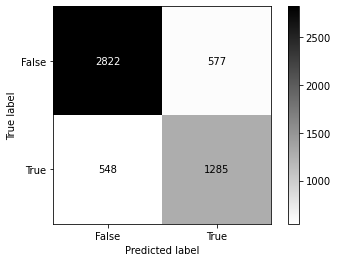

In [182]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn_crfsuite.utils import flatten


feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred))

In [186]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(10))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-10:])

Top positive:
1.073885 False    -1:POSTAG_NCD
0.732556 False    POSTAG_NEG
0.686396 False    f_suf_per_2.0
0.525726 False    +1:POSTAG_NEG
0.420602 False    -1:f_suf_per_2.0
0.413416 False    +1:f_suf_num_P
0.384165 False    -1:POSTAG_NEG
0.382567 False    +1:f_num_D
0.377129 True     is_client
0.365165 True     f_tense_IMPERATIVE

Top negative:
-0.365165 False    f_tense_IMPERATIVE
-0.377129 False    is_client
-0.382567 True     +1:f_num_D
-0.384165 True     -1:POSTAG_NEG
-0.413416 True     +1:f_suf_num_P
-0.420602 True     -1:f_suf_per_2.0
-0.525726 True     +1:POSTAG_NEG
-0.686396 True     f_suf_per_2.0
-0.732556 True     POSTAG_NEG
-1.073885 True     -1:POSTAG_NCD


## Sliding window - step size = 1/2 window

In [168]:
step = int(seq_len/2)
X = [seq2features(first_sent_idx) for first_sent_idx in merged_sent_pos.index[:-seq_len:step]]
y = [seq2labels(first_sent_idx) for first_sent_idx in merged_sent_pos.index[:-seq_len:step]]

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
print( len(X_train),len(X_test))

590 291


In [170]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
#     all_possible_transitions=True,
)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
y_pred = crf.predict(X_test)

0.760364921263774
              precision    recall  f1-score   support

       False       0.79      0.86      0.82      1116
        True       0.71      0.59      0.65       630

    accuracy                           0.77      1746
   macro avg       0.75      0.73      0.74      1746
weighted avg       0.76      0.77      0.76      1746



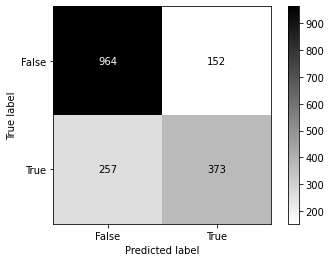

In [172]:
labels = list(crf.classes_)
print(metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels))
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred))

In [88]:
merged_raw =  pd.merge(sent_db[:300],sent_tokens_db,left_index=True,right_index=True,validate="one_to_one")
merged_raw

,is_nar,sent_len,first_sent_in_nar,last_sent_in_nar,is_client,FROM,sent_idx,TO,FORM,LEMMA,...,POSTAG,f_gen,f_num,FEATS,TOKEN,f_suf_gen,f_suf_num,f_suf_per,f_per,f_tense
0,0.000000,10.000000,False,False,0,0,0.000000,1,טוב,טוב,...,NNT,M,S,gen=M|num=S,1,NaN,NaN,NaN,NaN,NaN
1,0.000000,15.000000,False,False,1,1,0.000000,2,אהלן,אהלן,...,INTJ,NaN,NaN,_,2,NaN,NaN,NaN,NaN,NaN
2,0.000000,4.000000,False,False,0,2,0.000000,3,נ,נ,...,NNP,M,S,gen=F|gen=M|num=S,3,NaN,NaN,NaN,NaN,NaN
3,0.000000,8.000000,False,False,0,0,1.000000,1,היי,הי,...,INTJ,NaN,NaN,_,1,NaN,NaN,NaN,NaN,NaN
4,0.000000,73.000000,False,False,1,1,1.000000,2,מה,מה,...,QW,NaN,NaN,_,2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.000000,32.000000,False,False,0,11,24.000000,12,כאילו,כאילו,...,CC,NaN,NaN,_,9,NaN,NaN,NaN,NaN,NaN
296,0.000000,8.000000,False,False,0,12,24.000000,13,אנחנו,הוא,...,PRP,M,P,gen=F|gen=M|num=P|per=1,10,NaN,NaN,NaN,1,NaN
297,0.000000,34.000000,False,False,0,13,24.000000,14,כמה,כמה,...,DTT,NaN,NaN,_,11,NaN,NaN,NaN,NaN,NaN
298,0.000000,23.000000,False,False,0,14,24.000000,15,אנשים,איש,...,NN,M,P,gen=M|num=P,12,NaN,NaN,NaN,NaN,NaN


In [ ]:
def word2features(sent_idx):
    sent_len = sent_tokens_db[sent_tokens_db['sent_idx']==sent_idx]['TOKEN'].max()
    word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @word_idx")

    features = {
#         'bias': 1.0,
        'word':word_row['LEMMA'].item(),
        'postag': word_row['POSTAG'].item(),
        'gen': word_row['f_suf_gen'].item(),
        'num': word_row['f_suf_num'].item(),
        'suf_per': word_row['f_suf_per'].item(),
        'per': word_row['f_per'].item(),
        'tense': word_row['f_tense'].item(),
    }
    if word_idx > 1:
        one_before_idx = word_idx-1
        word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @one_before_idx")
        features.update({
            '-1:word':word_row['LEMMA'].item(),
        '-1:postag': word_row['POSTAG'].item(),
        '-1:gen': word_row['f_suf_gen'].item(),
        '-1:num':word_row['f_suf_num'].item(),
        '-1:suf_per': word_row['f_suf_per'].item(),
        '-1:per': word_row['f_per'].item(),
        '-1:tense': word_row['f_tense'].item(),
        })
    else:
        features['BOS'] = True
    
    if word_idx > 2:
        two_before_idx = word_idx-2
        word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @two_before_idx")
        features.update({
            '-2:word':word_row['LEMMA'].item(),
        '-2:postag': word_row['POSTAG'].item(),
        '-2:gen':word_row['f_suf_gen'].item(),
        '-2:num':word_row['f_suf_num'].item(),
        '-2:suf_per': word_row['f_suf_per'].item(),
        '-2:per': word_row['f_per'].item(),
        '-2:tense': word_row['f_tense'].item(),
        })

    if word_idx < sent_len:
        one_after_idx = word_idx+1
        word_row =  sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @one_after_idx")
        features.update({
            '+1:word':word_row['LEMMA'].item(),
        '+1:postag': word_row['POSTAG'].item(),
        '+1:gen': word_row['f_suf_gen'].item(),
        '+1:num': word_row['f_suf_num'].item(),
        '+1:suf_per': word_row['f_suf_per'].item(),
        '+1:per': word_row['f_per'].item(),
        '+1:tense': word_row['f_tense'].item(),
        })
    else:
        features['EOS'] = True

    return features

In [87]:
merged_count = pd.merge(sent_db[:300],sent_pos_db,left_index=True,right_index=True,validate="one_to_one")
merged_count

,is_nar,sent_len,first_sent_in_nar,last_sent_in_nar,is_client,POSTAG,f_gen,f_num,f_suf_gen,f_suf_num,f_suf_per,f_per,f_tense
0.000000,0.000000,10.000000,False,False,0,3,2,2,0,0,0,0,0
1.000000,0.000000,15.000000,False,False,1,4,1,1,0,0,0,0,0
2.000000,0.000000,4.000000,False,False,0,3,1,1,0,0,0,0,0
3.000000,0.000000,8.000000,False,False,0,3,1,1,1,1,1,0,0
4.000000,0.000000,73.000000,False,False,1,17,7,7,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295.000000,0.000000,32.000000,False,False,0,9,6,6,0,0,0,4,0
296.000000,0.000000,8.000000,False,False,0,4,2,2,0,0,0,2,0
297.000000,0.000000,34.000000,False,False,0,12,5,5,0,0,0,3,1
298.000000,0.000000,23.000000,False,False,0,7,3,3,0,0,0,2,0


In [157]:
merged.describe()

,is_nar,sent_len,is_client,CPOSTAG,POSTAG,f_gen,f_num,f_suf_gen,f_suf_num,f_suf_per,f_per,f_tense
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.566667,35.273333,0.763333,10.436667,10.436667,5.043333,5.043333,0.110000,0.110000,0.110000,2.716667,0.616667
std,0.496364,31.243332,0.425746,9.328956,9.328956,4.611472,4.611472,0.380855,0.380855,0.380855,2.721718,0.982994
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,13.000000,1.000000,4.000000,4.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,27.000000,1.000000,8.000000,8.000000,4.000000,4.000000,0.000000,0.000000,0.000000,2.000000,0.000000
75%,1.000000,50.000000,1.000000,14.000000,14.000000,7.000000,7.000000,0.000000,0.000000,0.000000,4.000000,1.000000
max,1.000000,187.000000,1.000000,62.000000,62.000000,30.000000,30.000000,3.000000,3.000000,3.000000,16.000000,6.000000


In [ ]:
sns.pairplot(hue="is_nar", data=merged)

<AxesSubplot:xlabel='is_nar', ylabel='count'>

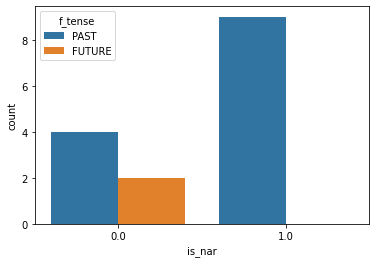

In [77]:
sns.countplot(x='is_nar',hue="f_tense", data=merged_raw)
# g = sns.catplot(x="class", hue="who", col="survived",
#                 data=titanic, kind="count",
#                 height=4, aspect=.7);

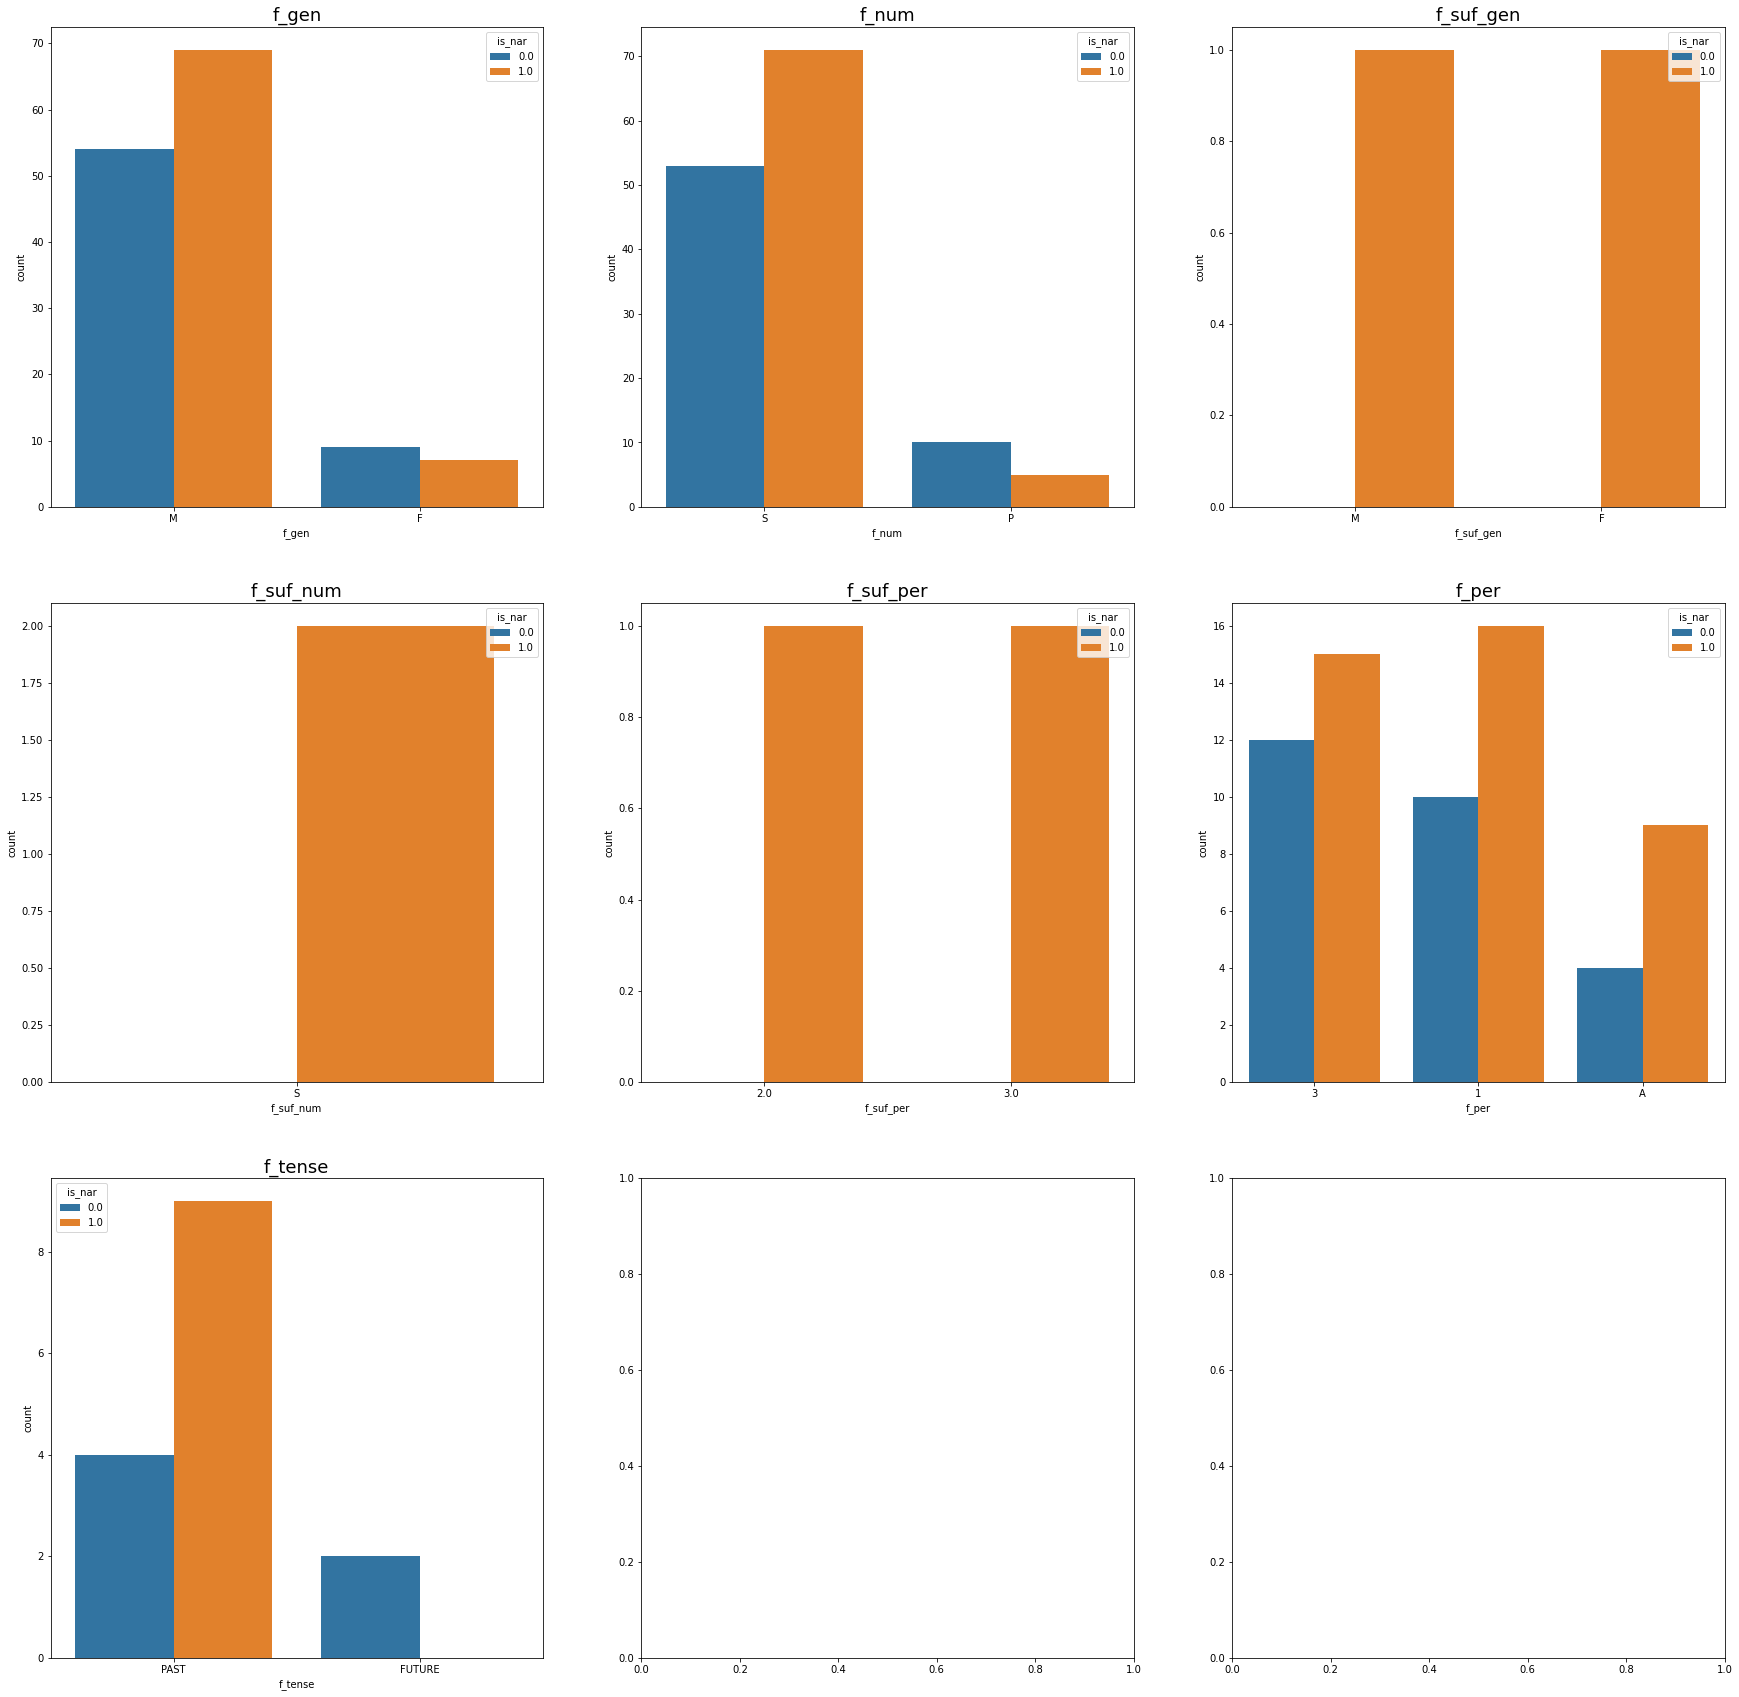

In [100]:
plot_num = len(columns_to_count)
fig, axes = plt.subplots(3, 3, figsize=(30,30))
for i,col in enumerate(columns_to_count[1:]):
    ax = axes.ravel()[i]
    sns.countplot(x=col,hue='is_nar', data=merged_raw,ax=ax)
#     df.boxplot('SalePrice',r2_scores[i,0], ax=ax) #TBD add weigths on X axis
    ax.set_title("{}".format(col), fontsize=18)

<AxesSubplot:xlabel='POSTAG'>

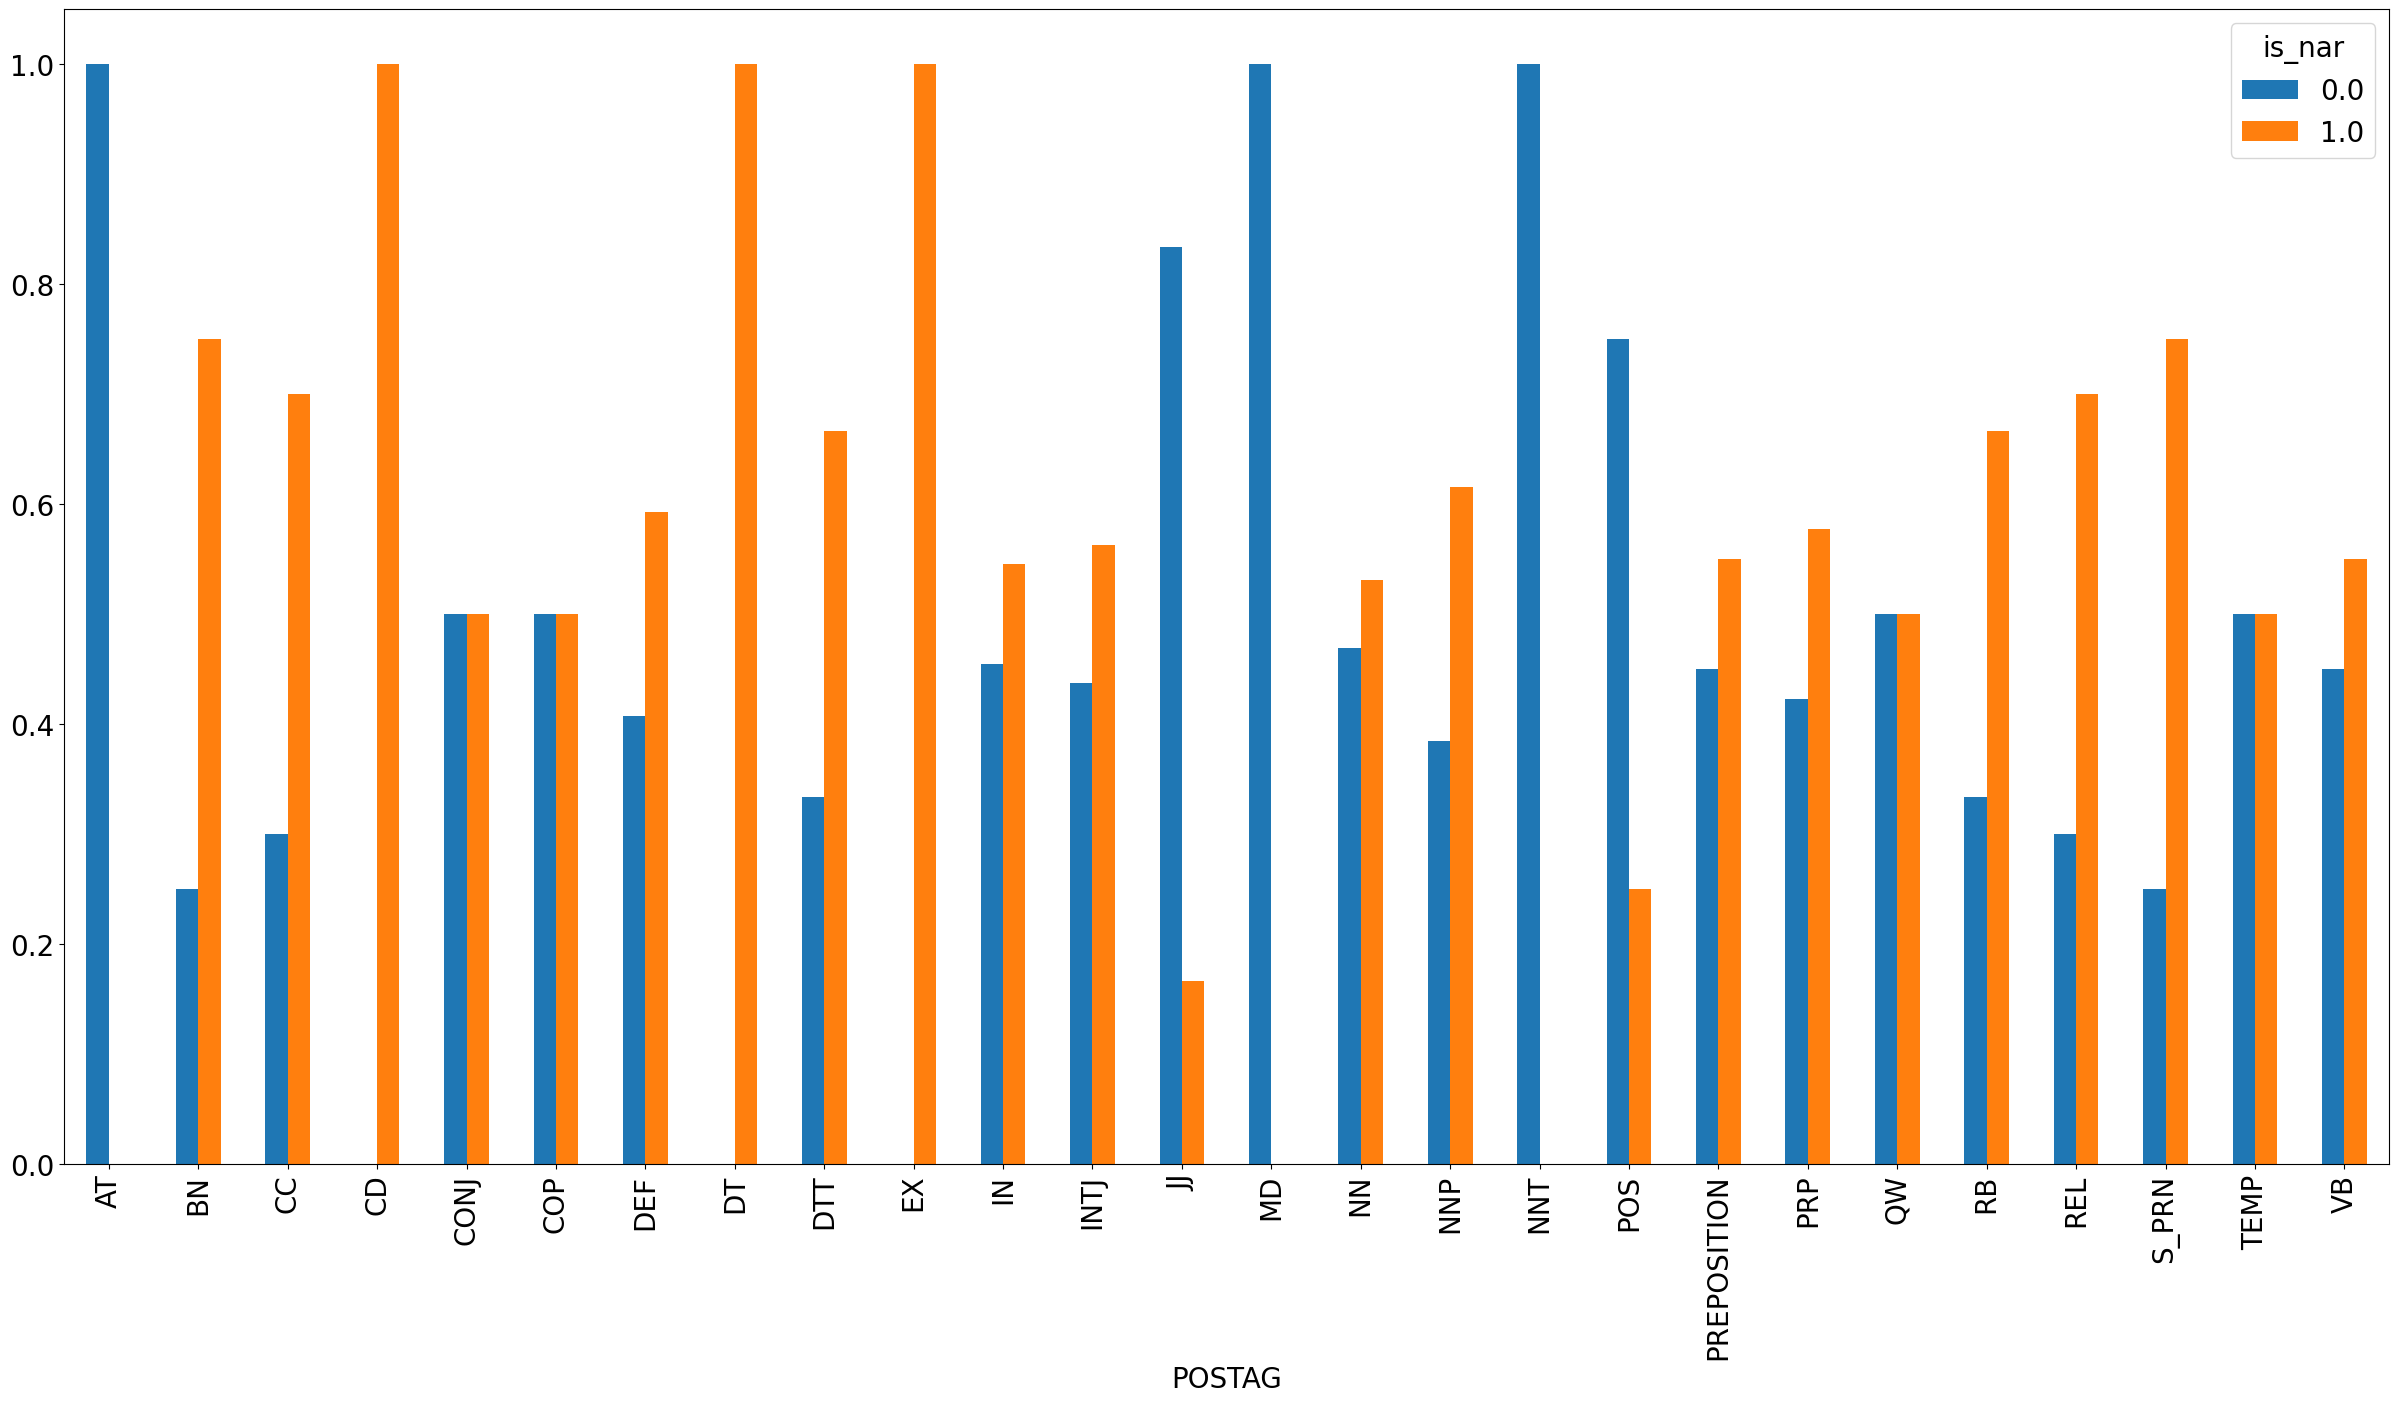

In [133]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, figsize=(30,15))
merged_raw.groupby([columns_to_count[0]])['is_nar'].value_counts(normalize=True).unstack().plot(kind='bar',ax=ax)

In [155]:
tags = merged_raw[columns_to_count[0]].unique()

In [156]:
imp.reload(defines)
imp.reload(feature_utils)
for tag in tags:
    print("{} : {}".format(tag,feature_utils.get_yap_tag_description(tag)))

NNT : Noun in construct state form
INTJ : Interjection
NNP : Proper noun
QW : WH words like when, where and how, which do not appear in a determiner position
DEF : Determiner
NN : NOUN
PREPOSITION : PREPOSITION
REL : The relativizers she, aher and ha (=that)
JJ : The construct state form of adjectives (like pitiless)
RB : Adverb
COP : Auxiliary verb = cop
CC : Coordinating conjunction
PRP : Personal pronoun
VB : A verb
IN : Preposition
DTT : definite article
TEMP : TEMP
CONJ : conjunction
BN : VERB-VerbForm=Part
EX :  VERB-HebExistential=True
DT : definite article
POS : Possessive item
S_PRN : Declarative sentence Parenthetical
AT : Accusative marker
CD : Numeral
MD : Modal


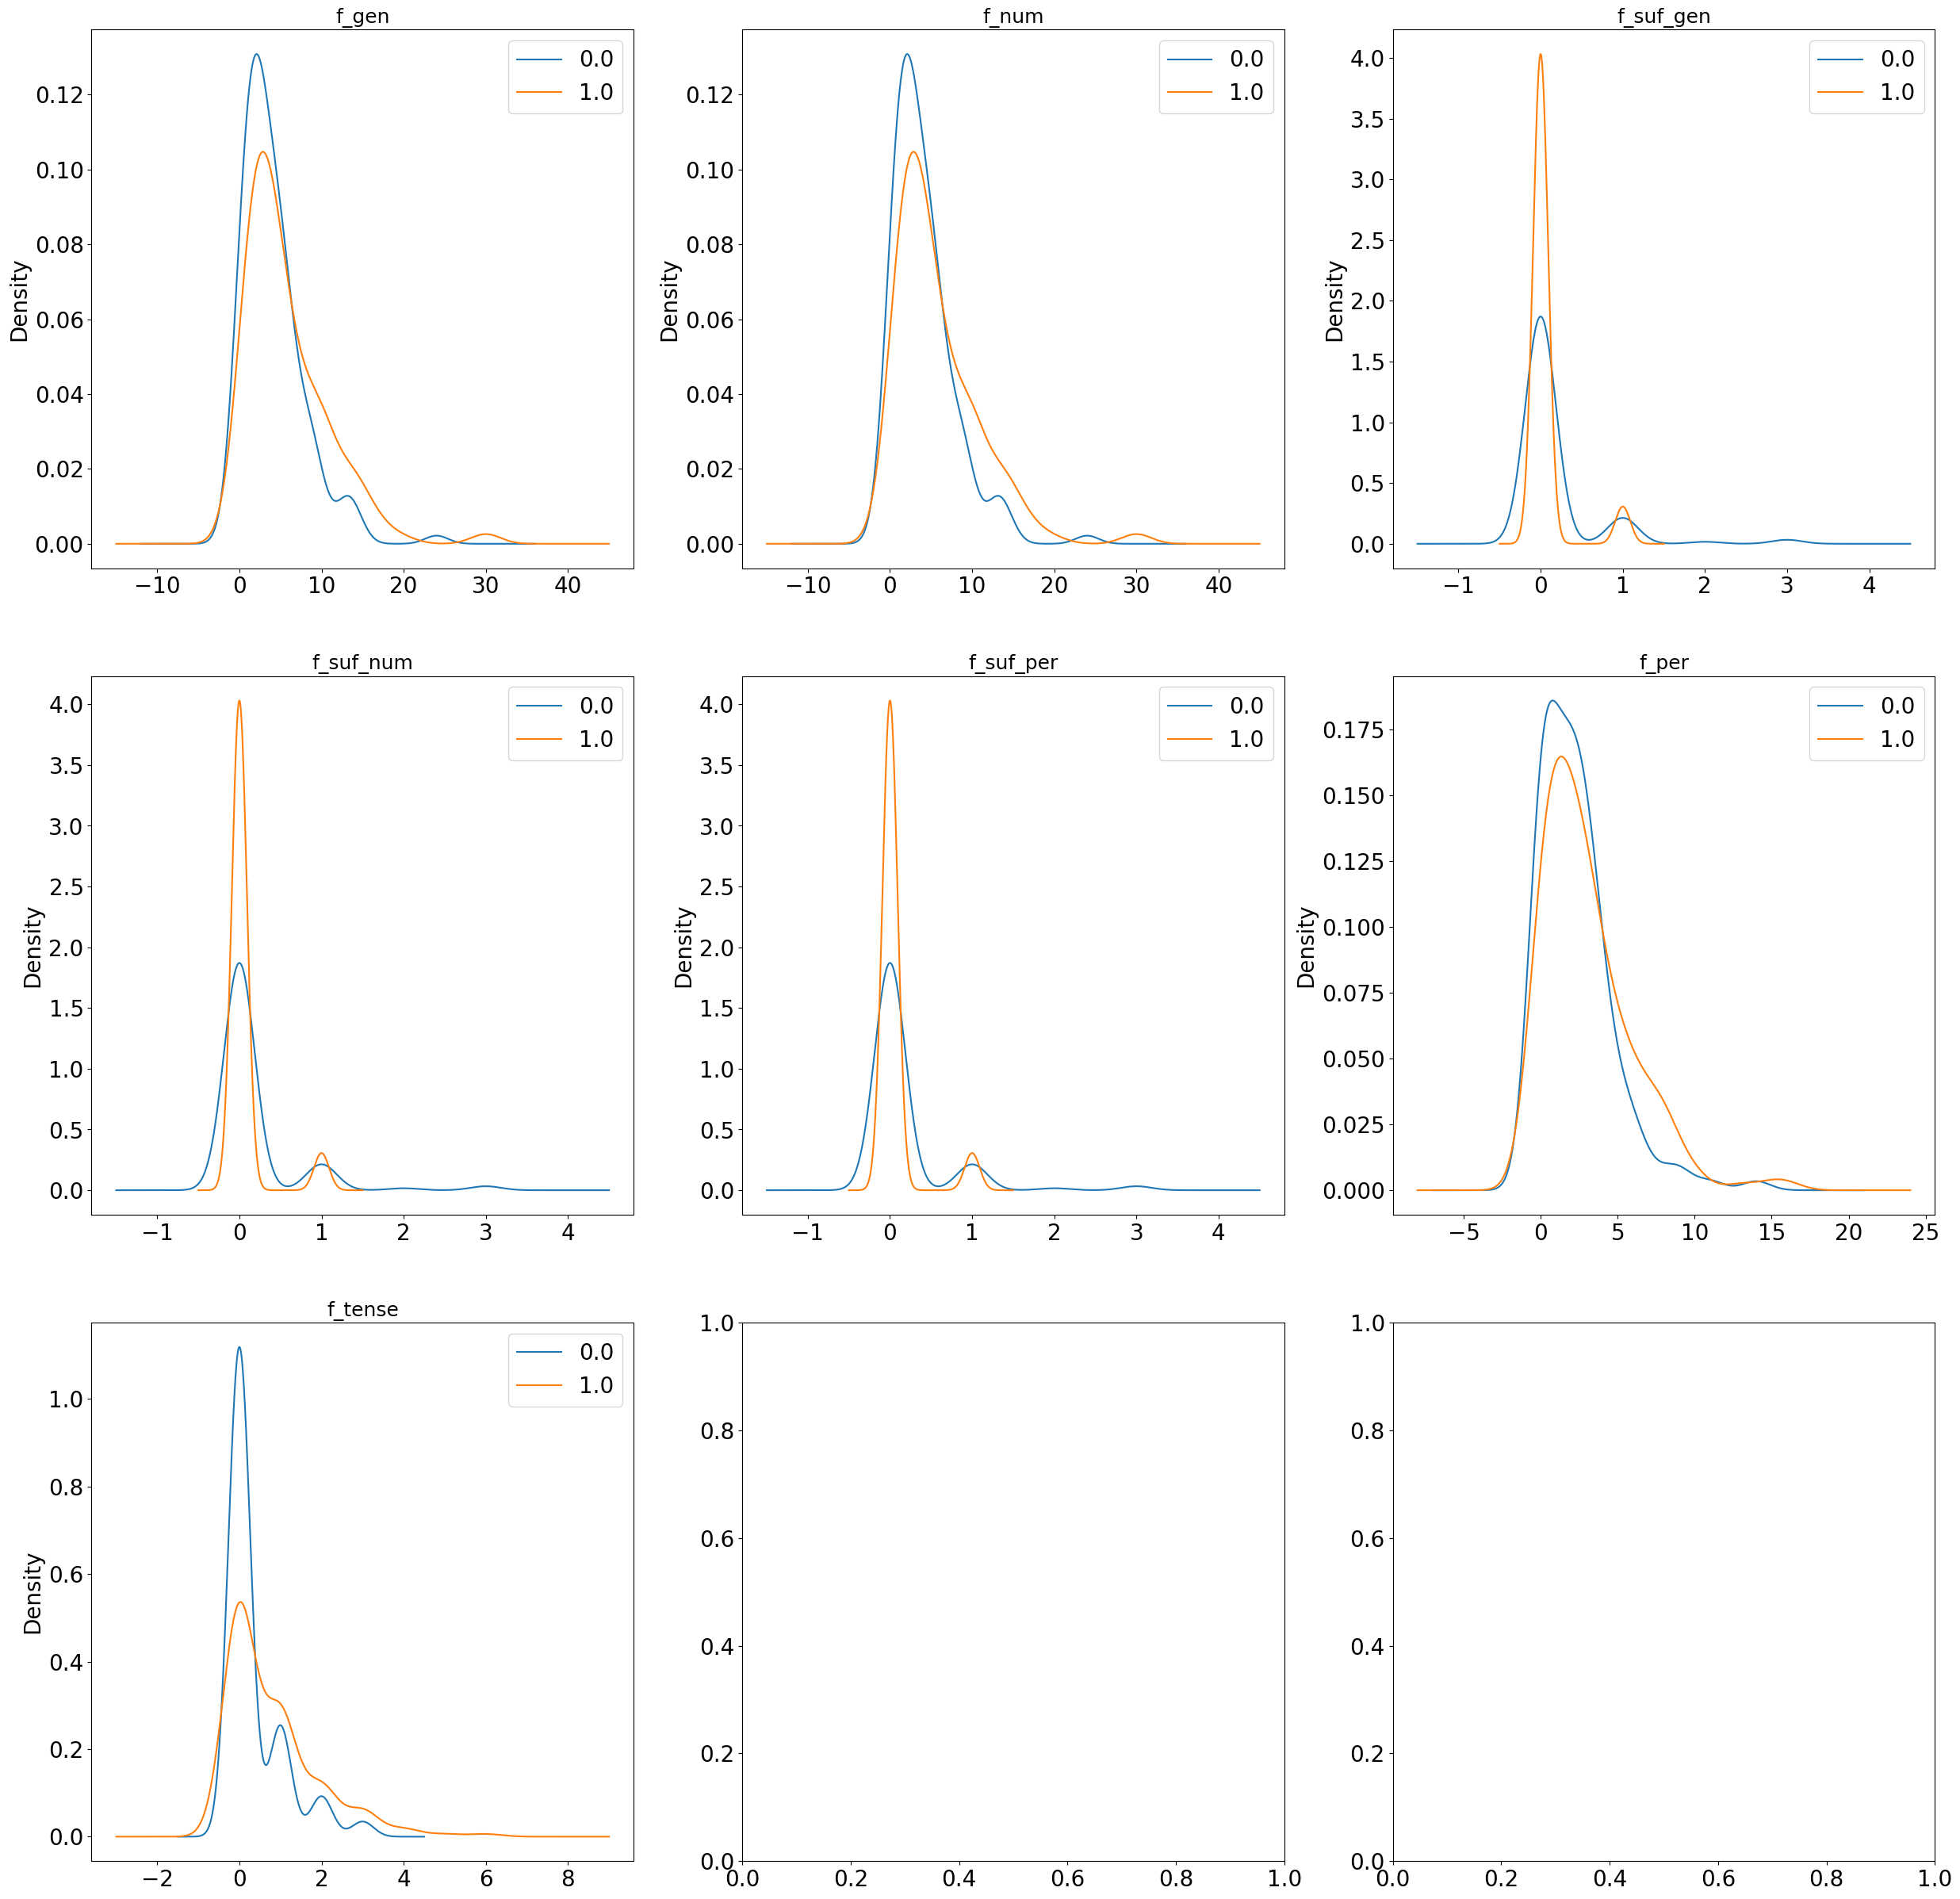

In [171]:
fig, axes = plt.subplots(3, 3, figsize=(30,30))
for i,col in enumerate(columns_to_count[1:]):
    ax = axes.ravel()[i]
    merged.groupby('is_nar')[col].plot(ax=ax,kind='kde',legend=True)#     df.boxplot('SalePrice',r2_scores[i,0], ax=ax) #TBD add weigths on X axis
    ax.set_title("{}".format(col), fontsize=18)
# merged.groupby('is_nar').plot(ax=ax,kind='kde',legend=True)

In [86]:
# Feature set
def word2features(sent_idx,word_idx):
    sent_len = sent_tokens_db[sent_tokens_db['sent_idx']==sent_idx]['TOKEN'].max()
    word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @word_idx")

    features = {
#         'bias': 1.0,
        'word':word_row['LEMMA'].item(),
        'postag': word_row['POSTAG'].item(),
        'gen': word_row['f_suf_gen'].item(),
        'num': word_row['f_suf_num'].item(),
        'suf_per': word_row['f_suf_per'].item(),
        'per': word_row['f_per'].item(),
        'tense': word_row['f_tense'].item(),
    }
    if word_idx > 1:
        one_before_idx = word_idx-1
        word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @one_before_idx")
        features.update({
            '-1:word':word_row['LEMMA'].item(),
        '-1:postag': word_row['POSTAG'].item(),
        '-1:gen': word_row['f_suf_gen'].item(),
        '-1:num':word_row['f_suf_num'].item(),
        '-1:suf_per': word_row['f_suf_per'].item(),
        '-1:per': word_row['f_per'].item(),
        '-1:tense': word_row['f_tense'].item(),
        })
    else:
        features['BOS'] = True
    
    if word_idx > 2:
        two_before_idx = word_idx-2
        word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @two_before_idx")
        features.update({
            '-2:word':word_row['LEMMA'].item(),
        '-2:postag': word_row['POSTAG'].item(),
        '-2:gen':word_row['f_suf_gen'].item(),
        '-2:num':word_row['f_suf_num'].item(),
        '-2:suf_per': word_row['f_suf_per'].item(),
        '-2:per': word_row['f_per'].item(),
        '-2:tense': word_row['f_tense'].item(),
        })

    if word_idx < sent_len:
        one_after_idx = word_idx+1
        word_row =  sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @one_after_idx")
        features.update({
            '+1:word':word_row['LEMMA'].item(),
        '+1:postag': word_row['POSTAG'].item(),
        '+1:gen': word_row['f_suf_gen'].item(),
        '+1:num': word_row['f_suf_num'].item(),
        '+1:suf_per': word_row['f_suf_per'].item(),
        '+1:per': word_row['f_per'].item(),
        '+1:tense': word_row['f_tense'].item(),
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent_idx):
    return [word2features(sent_idx,word_idx) for word_idx in sent_tokens_db[sent_tokens_db['sent_idx']==sent_idx]['TOKEN']]


# def sent2labels(sent):
#     return [sent_tokens_db.iloc[word,'is_nar'] for word in sent_tokens_db.index]
#Creating the train and test set
X = [sent2features(sent_idx) for sent_idx in sent_tokens_db['sent_idx'].unique()[:1]]
# y = [sent2labels(s) for s in sentences]
# X = [sent2features(1)]

In [87]:
X

[[{'word': 'טוב',
   'postag': 'NNT',
   'gen': nan,
   'num': nan,
   'suf_per': nan,
   'per': nan,
   'tense': nan,
   'BOS': True,
   '+1:word': 'אהלן',
   '+1:postag': 'INTJ',
   '+1:gen': nan,
   '+1:num': nan,
   '+1:suf_per': nan,
   '+1:per': nan,
   '+1:tense': nan},
  {'word': 'אהלן',
   'postag': 'INTJ',
   'gen': nan,
   'num': nan,
   'suf_per': nan,
   'per': nan,
   'tense': nan,
   '-1:word': 'טוב',
   '-1:postag': 'NNT',
   '-1:gen': nan,
   '-1:num': nan,
   '-1:suf_per': nan,
   '-1:per': nan,
   '-1:tense': nan,
   '+1:word': 'נ',
   '+1:postag': 'NNP',
   '+1:gen': nan,
   '+1:num': nan,
   '+1:suf_per': nan,
   '+1:per': nan,
   '+1:tense': nan},
  {'word': 'נ',
   'postag': 'NNP',
   'gen': nan,
   'num': nan,
   'suf_per': nan,
   'per': nan,
   'tense': nan,
   '-1:word': 'אהלן',
   '-1:postag': 'INTJ',
   '-1:gen': nan,
   '-1:num': nan,
   '-1:suf_per': nan,
   '-1:per': nan,
   '-1:tense': nan,
   '-2:word': 'טוב',
   '-2:postag': 'NNT',
   '-2:gen': nan,
 

In [193]:
def seq2features(seq_idx):
    seq = []
    for s in range(seq_idx,seq_idx+seq_len):
         seq.extend(sent2features(s))
    return seq

def seq2labels(seq_idx):
    seq = []
    for s in range(seq_idx,seq_idx+seq_len):
        label = sent2labels(s)
        seq.extend([label for i in range(vec_dim)]) # 2 - for 2 more featues EOS and BOS
    return seq

In [195]:
X[0], y[0]

(['v0',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6',
  'v7',
  'v8',
  'v9',
  'v10',
  'v11',
  'v12',
  'v13',
  'v14',
  'v15',
  'v16',
  'v17',
  'v18',
  'v19',
  'v20',
  'v21',
  'v22',
  'v23',
  'v24',
  'v25',
  'v26',
  'v27',
  'v28',
  'v29',
  'v30',
  'v31',
  'v32',
  'v33',
  'v34',
  'v35',
  'v36',
  'v37',
  'v38',
  'v39',
  'v40',
  'v41',
  'v42',
  'v43',
  'v44',
  'v45',
  'v46',
  'v47',
  'v48',
  'v49',
  'v50',
  'v51',
  'v52',
  'v53',
  'v54',
  'v55',
  'v56',
  'v57',
  'v58',
  'v59',
  'v60',
  'v61',
  'v62',
  'v63',
  'v64',
  'v65',
  'v66',
  'v67',
  'v68',
  'v69',
  'v70',
  'v71',
  'v72',
  'v73',
  'v74',
  'v75',
  'v76',
  'v77',
  'v78',
  'v79',
  'v80',
  'v81',
  'v82',
  'v83',
  'v84',
  'v85',
  'v86',
  'v87',
  'v88',
  'v89',
  'v90',
  'v91',
  'v92',
  'v93',
  'v94',
  'v95',
  'v96',
  'v97',
  'v98',
  'v99',
  'BOS',
  'v0',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6',
  'v7',
  'v8',
  'v9',
  'v10',
  'v11',
  '

In [196]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [197]:
len(X_train), len(y_train), len(X_test), len(y_test)

(469, 469, 231, 231)

In [198]:
# from sklearn.metrics import make_scorer
# from sklearn_crfsuite import metrics
# f1_scorer = make_scorer(metrics.flat_f1_score, average='macro') 
from sklearn.model_selection import cross_validate

crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
#     all_possible_transitions=True,
)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
predictions = crf.predict(X_test)
# pred = cross_val_predict(estimator=crf, X=X_train, y=y_train, cv=5)
# scores = cross_validate(crf, X, y, scoring="f1_macro", cv=5)
# print(scores.test_score)

ValueError: The numbers of items and labels differ: |x| = 402, |y| = 408

In [171]:
predictions
# feature_utils.get_prediction_report(y_test,predictions)

[['v0',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6',
  'v7',
  'v8',
  'v9',
  'v10',
  'v11',
  'v12',
  'v13',
  'v14',
  'v15',
  'v16',
  'v17',
  'v18',
  'v19',
  'v20',
  'v21',
  'v22',
  'v23',
  'v24',
  'v25',
  'v26',
  'v27',
  'v28',
  'v29',
  'v30',
  'v31',
  'v32',
  'v33',
  'v34',
  'v35',
  'v36',
  'v37',
  'v38',
  'v39',
  'v40',
  'v41',
  'v42',
  'v43',
  'v44',
  'v45',
  'v46',
  'v47',
  'v48',
  'v49',
  'v50',
  'v51',
  'v52',
  'v53',
  'v54',
  'v55',
  'v56',
  'v57',
  'v58',
  'v59',
  'v60',
  'v61',
  'v62',
  'v63',
  'v64',
  'v65',
  'v66',
  'v67',
  'v68',
  'v69',
  'v70',
  'v71',
  'v72',
  'v73',
  'v74',
  'v75',
  'v76',
  'v77',
  'v78',
  'v79',
  'v80',
  'v81',
  'v82',
  'v83',
  'v84',
  'v85',
  'v86',
  'v87',
  'v88',
  'v89',
  'v90',
  'v91',
  'v92',
  'v93',
  'v94',
  'v95',
  'v96',
  'v97',
  'v98',
  'v99',
  'BOS',
  'v0',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6',
  'v7',
  'v8',
  'v9',
  'v10',
  'v11',
  '

In [51]:
sent_vec_db

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,is_nar,sent_len
0,-0.114521,0.000108,0.036471,-0.024207,0.002051,0.014730,-0.104159,0.058651,0.005404,0.056529,...,-0.002414,0.039244,-0.094238,0.025045,0.097398,-0.004409,0.041561,-0.049388,0.0,9.0
1,-0.013333,0.000648,0.013545,-0.001843,0.037912,0.044653,-0.033737,0.020353,-0.039255,0.040033,...,0.038335,0.013976,-0.062025,-0.025751,-0.032749,0.038144,-0.012054,0.083821,0.0,7.0
2,-0.049959,0.006207,0.019215,-0.013564,-0.006140,-0.020194,-0.021590,0.033078,0.043775,0.076063,...,-0.021449,-0.031051,-0.009857,0.012590,0.040845,-0.031004,0.001470,-0.049673,0.0,6.0
3,-0.009683,0.047087,0.037459,0.019149,0.005652,-0.042241,0.013978,0.052192,-0.023080,0.002327,...,-0.029806,0.033418,-0.029150,0.014673,0.022372,0.058281,0.031803,-0.026994,0.0,18.0
4,0.060957,0.005640,-0.018319,-0.002478,0.010457,-0.024910,0.091064,0.000475,0.066396,-0.038925,...,-0.024806,-0.046600,-0.026737,-0.015007,0.005086,0.030338,0.038523,-0.014919,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,0.044579,0.024742,0.028893,-0.060388,0.039829,0.025243,-0.117620,-0.028324,0.013425,-0.002992,...,-0.027126,-0.003454,-0.037883,0.018410,0.046375,0.052125,-0.023152,0.060160,0.0,3.0
2835,0.017902,0.038459,-0.016246,-0.003681,-0.026354,0.042227,0.019360,0.023875,-0.001420,0.015527,...,-0.022408,0.012324,-0.014626,0.004259,0.006237,0.035307,0.027554,-0.016158,0.0,30.0
2836,0.013650,0.023375,0.017228,0.000760,0.006687,0.010800,-0.005754,0.013923,0.009729,0.018878,...,-0.015082,0.006376,-0.010457,0.021521,-0.011850,0.022129,0.016181,0.004594,0.0,37.0
2837,0.009727,0.017978,0.027529,0.006578,0.020192,-0.020603,0.027635,0.017854,0.040842,0.017801,...,-0.019581,-0.002811,-0.012890,0.033547,0.007128,-0.002388,0.006980,-0.007728,0.0,23.0
